In [1]:
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.io.img_tiles import Stamen
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib import cm
import datetime
# import nc_time_axis
# from cftime import DatetimeNoLeap
import numpy as np
import xarray as xr
from flox.xarray import xarray_reduce
import dask
from dask.diagnostics import ProgressBar
# from braceexpand import braceexpand
import pandas as pd
from math import cos, asin, sqrt, pi
%matplotlib inline
%config InlineBackend.figure_format='retina'
# This code make the next section of code to stop acting silly
dask.config.set({"array.slicing.split_large_chunks": True})
	# True: smaller chunks are used
	# False: large chunks are accepted

#### Functions

In [2]:
# Purpose: Create a LocalTime coordinate within your DataArray.

# Input:
    # da = xr.DataArray;  Must be in shape: time x south_north x west_east
		# Make sure west_east/XLONG values are 0->360, not -180->+180
	# dim_num = 2 or 3;  This indicates to the function if you want Local Time
		# within the dataarray to be only a function of time and longitude, or
		# time, lognitude, and latitude. This is a preference and if you don't need
		# it as a function of latitude, it will save lots of time going with dim_num = 2.
# Output:
    # da: This will be the DataArray with the newly assigned coordinate
# Process:
    # First create a matrix of hours to be offset relative to UTC.
    # Create an empty array that has dimensions Time and Longitude.
    # Loop through each timestep and longitude to determine the local time.
    # Assign the new Local Time coordinate to the da and return it.


def assign_LT_coord(da, dim_num):
	hour_offset = (da.longitude.values/15).round(decimals=0)

	# Local Time is a function of only Time and Longitude
	if dim_num==2:
		local_time = np.empty([len(da.time),len(da.longitude)], dtype=object)
		for i in range(local_time.shape[0]):
			for j in range(local_time.shape[1]):
				local_time[i,j] = da.time.values[i] + np.timedelta64(int(hour_offset[j]),'h')
		da = da.assign_coords(LocalTime=(('time','longitude'),local_time))
	
	# Local Time is a function of Time, Longitude, and Latitude
	else:
		local_time = np.empty([len(da.time),len(da.latitude),len(da.longitude)], dtype='datetime64[ns]')
		for i in range(local_time.shape[0]):
			for j in range(local_time.shape[2]):
				local_time[i,:,j] = da.time.values[i] + np.timedelta64(int(hour_offset[j]),'h')
		da = da.assign_coords(LocalTime=(('time','latitude','longitude'),local_time))
	return da


In [3]:
def dist(lat1, lon1, lat2, lon2):
    r = 6371 # km
    p = pi / 180

    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 2 * r * asin(sqrt(a))

In [4]:
# To slice and save .nc files

def slice_and_save_netcdf(files, lats, lons, times, levels, output_dir, integrate_bool):
	"""
	Slices and saves NetCDF files for a specified spatial and temporal range.

	Parameters:
	files (str or list of str): Path(s) to the input NetCDF file(s).
	latitude (list): Latitude range [min_lat, max_lat].
	longitude (list): Longitude range [min_lon, max_lon].
	times (list): Time range [start_time, end_time] in string format.
	levels (list): Level range [top_level, bottom_level] in string format.	i.e. [100, 1000] or [750]	in hPa
	output_dir (str): Directory where sliced files will be saved.
	integrate_bool (bool): Set True if you want it to be vertically integrated

	"""
	# Open dataset
	ds = xr.open_mfdataset(files)
	
	# Slice dataset
	ds = ds.sel(
		latitude=slice(lats[0],lats[1]),
		longitude=slice(lons[0],lons[1]),
		time=slice(times[0],times[1]))
	# Multiple levels versus just one
	if len(levels)>1: 	ds = ds.sel(level=slice(levels[0],levels[1]))
	else: 				ds = ds.sel(level=levels)
	
	# Vertically integrate via trapezoidal rule, and save as netcdf file
	if integrate_bool:
		ds.integrate(coord='level').to_netcdf(path=output_dir, mode='w', format='NETCDF4', unlimited_dims='time', compute=True)
	else:
		ds.to_netcdf(path=output_dir, mode='w', format='NETCDF4', unlimited_dims='time', compute=True)

	return


#### Save Data

In [64]:
# ## Vertically Integrated specific humidity	(kg/m^2)
# files = ['/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/q.201511.nc',
# 		'/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/q.201512.nc']
# lats = [10, -10]
# lons = [90, 125]
# times = ['2015-11-23 00:00','2015-12-03 00:00']
# levels = [100, 1000]
# output_dir = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/ERA5-int_q-_2015-11-23-00:00-12-03-00:00.nc'
# integrate_bool = True

# slice_and_save_netcdf(files, lats, lons, times, levels, output_dir, integrate_bool)
# times = ['2015-12-10 00:00','2015-12-20 00:00']
# output_dir = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/ERA5-int_q-_2015-12-10-00:00-12-20-00:00.nc'
# slice_and_save_netcdf(files, lats, lons, times, levels, output_dir, integrate_bool)


# ## 700 hPa specific humidity (kg/kg)
# files = ['/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/q.201511.nc',
# 		'/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/q.201512.nc']
# lats = [10, -10]
# lons = [90, 125]
# times = ['2015-11-23 00:00','2015-12-03 00:00']
# levels = [700]
# output_dir = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/ERA5-q700-_2015-11-23-00:00-12-03-00:00.nc'
# integrate_bool = False

# slice_and_save_netcdf(files, lats, lons, times, levels, output_dir, integrate_bool)
# times = ['2015-12-10 00:00','2015-12-20 00:00']
# output_dir = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/ERA5-q700-_2015-12-10-00:00-12-20-00:00.nc'
# slice_and_save_netcdf(files, lats, lons, times, levels, output_dir, integrate_bool)


# ## 850-hPa zonal winds	(m/s)
# files = ['/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/uwnd.201511.nc',
# 		'/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/uwnd.201512.nc']
# lats = [10, -10]
# lons = [90, 125]
# times = ['2015-11-23 00:00','2015-12-03 00:00']
# levels = [850]
# output_dir = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/ERA5-u850-_2015-11-23-00:00-12-03-00:00.nc'
# integrate_bool = False

# slice_and_save_netcdf(files, lats, lons, times, levels, output_dir, integrate_bool)
# times = ['2015-12-10 00:00','2015-12-20 00:00']
# output_dir = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/ERA5-u850-_2015-12-10-00:00-12-20-00:00.nc'
# slice_and_save_netcdf(files, lats, lons, times, levels, output_dir, integrate_bool)

#### Load Data

In [5]:
## Vertically Integrated specific humidity
intq_filename_old = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/ERA5-int_q-_2015-11-23-00:00-12-03-00:00.nc'
intq_filename_new = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/ERA5-int_q-_2015-12-10-00:00-12-20-00:00.nc'
## 700-hPa specific humidity
q700_filename_old = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/ERA5-q700-_2015-11-23-00:00-12-03-00:00.nc'
q700_filename_new = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/ERA5-q700-_2015-12-10-00:00-12-20-00:00.nc'
## 850-hPa Zonal winds
u850_filename_old = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/ERA5-u850-_2015-11-23-00:00-12-03-00:00.nc'
u850_filename_new = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/ERA5-u850-_2015-12-10-00:00-12-20-00:00.nc'

lat_bound = [10,-10]	# South to North
lon_bound = [90,125]	# West to East

ds_intq_old = xr.open_dataset(intq_filename_old)
ds_intq_new = xr.open_dataset(intq_filename_new)
ds_q700_old = xr.open_dataset(q700_filename_old)
ds_q700_new = xr.open_dataset(q700_filename_new)
ds_u850_old = xr.open_dataset(u850_filename_old)
ds_u850_new = xr.open_dataset(u850_filename_new)

da_intq_old = ds_intq_old['q'].sel(longitude=slice(lon_bound[0],lon_bound[1]),latitude=slice(lat_bound[0],lat_bound[1])).compute()
da_intq_new = ds_intq_new['q'].sel(longitude=slice(lon_bound[0],lon_bound[1]),latitude=slice(lat_bound[0],lat_bound[1])).compute()
da_q700_old = ds_q700_old['q'].sel(longitude=slice(lon_bound[0],lon_bound[1]),latitude=slice(lat_bound[0],lat_bound[1])).compute().squeeze()
da_q700_new = ds_q700_new['q'].sel(longitude=slice(lon_bound[0],lon_bound[1]),latitude=slice(lat_bound[0],lat_bound[1])).compute().squeeze()
da_u850_old = ds_u850_old['uwnd'].sel(longitude=slice(lon_bound[0],lon_bound[1]),latitude=slice(lat_bound[0],lat_bound[1])).compute().squeeze()
da_u850_new = ds_u850_new['uwnd'].sel(longitude=slice(lon_bound[0],lon_bound[1]),latitude=slice(lat_bound[0],lat_bound[1])).compute().squeeze()

## Add local time coordinates
da_intq_old = assign_LT_coord(da_intq_old, dim_num=3)
da_intq_new = assign_LT_coord(da_intq_new, dim_num=3)
da_q700_old = assign_LT_coord(da_q700_old, dim_num=3)
da_q700_new = assign_LT_coord(da_q700_new, dim_num=3)
da_u850_old = assign_LT_coord(da_u850_old, dim_num=3)
da_u850_new = assign_LT_coord(da_u850_new, dim_num=3)

#### Domain Analysis

##### Time Average

U850

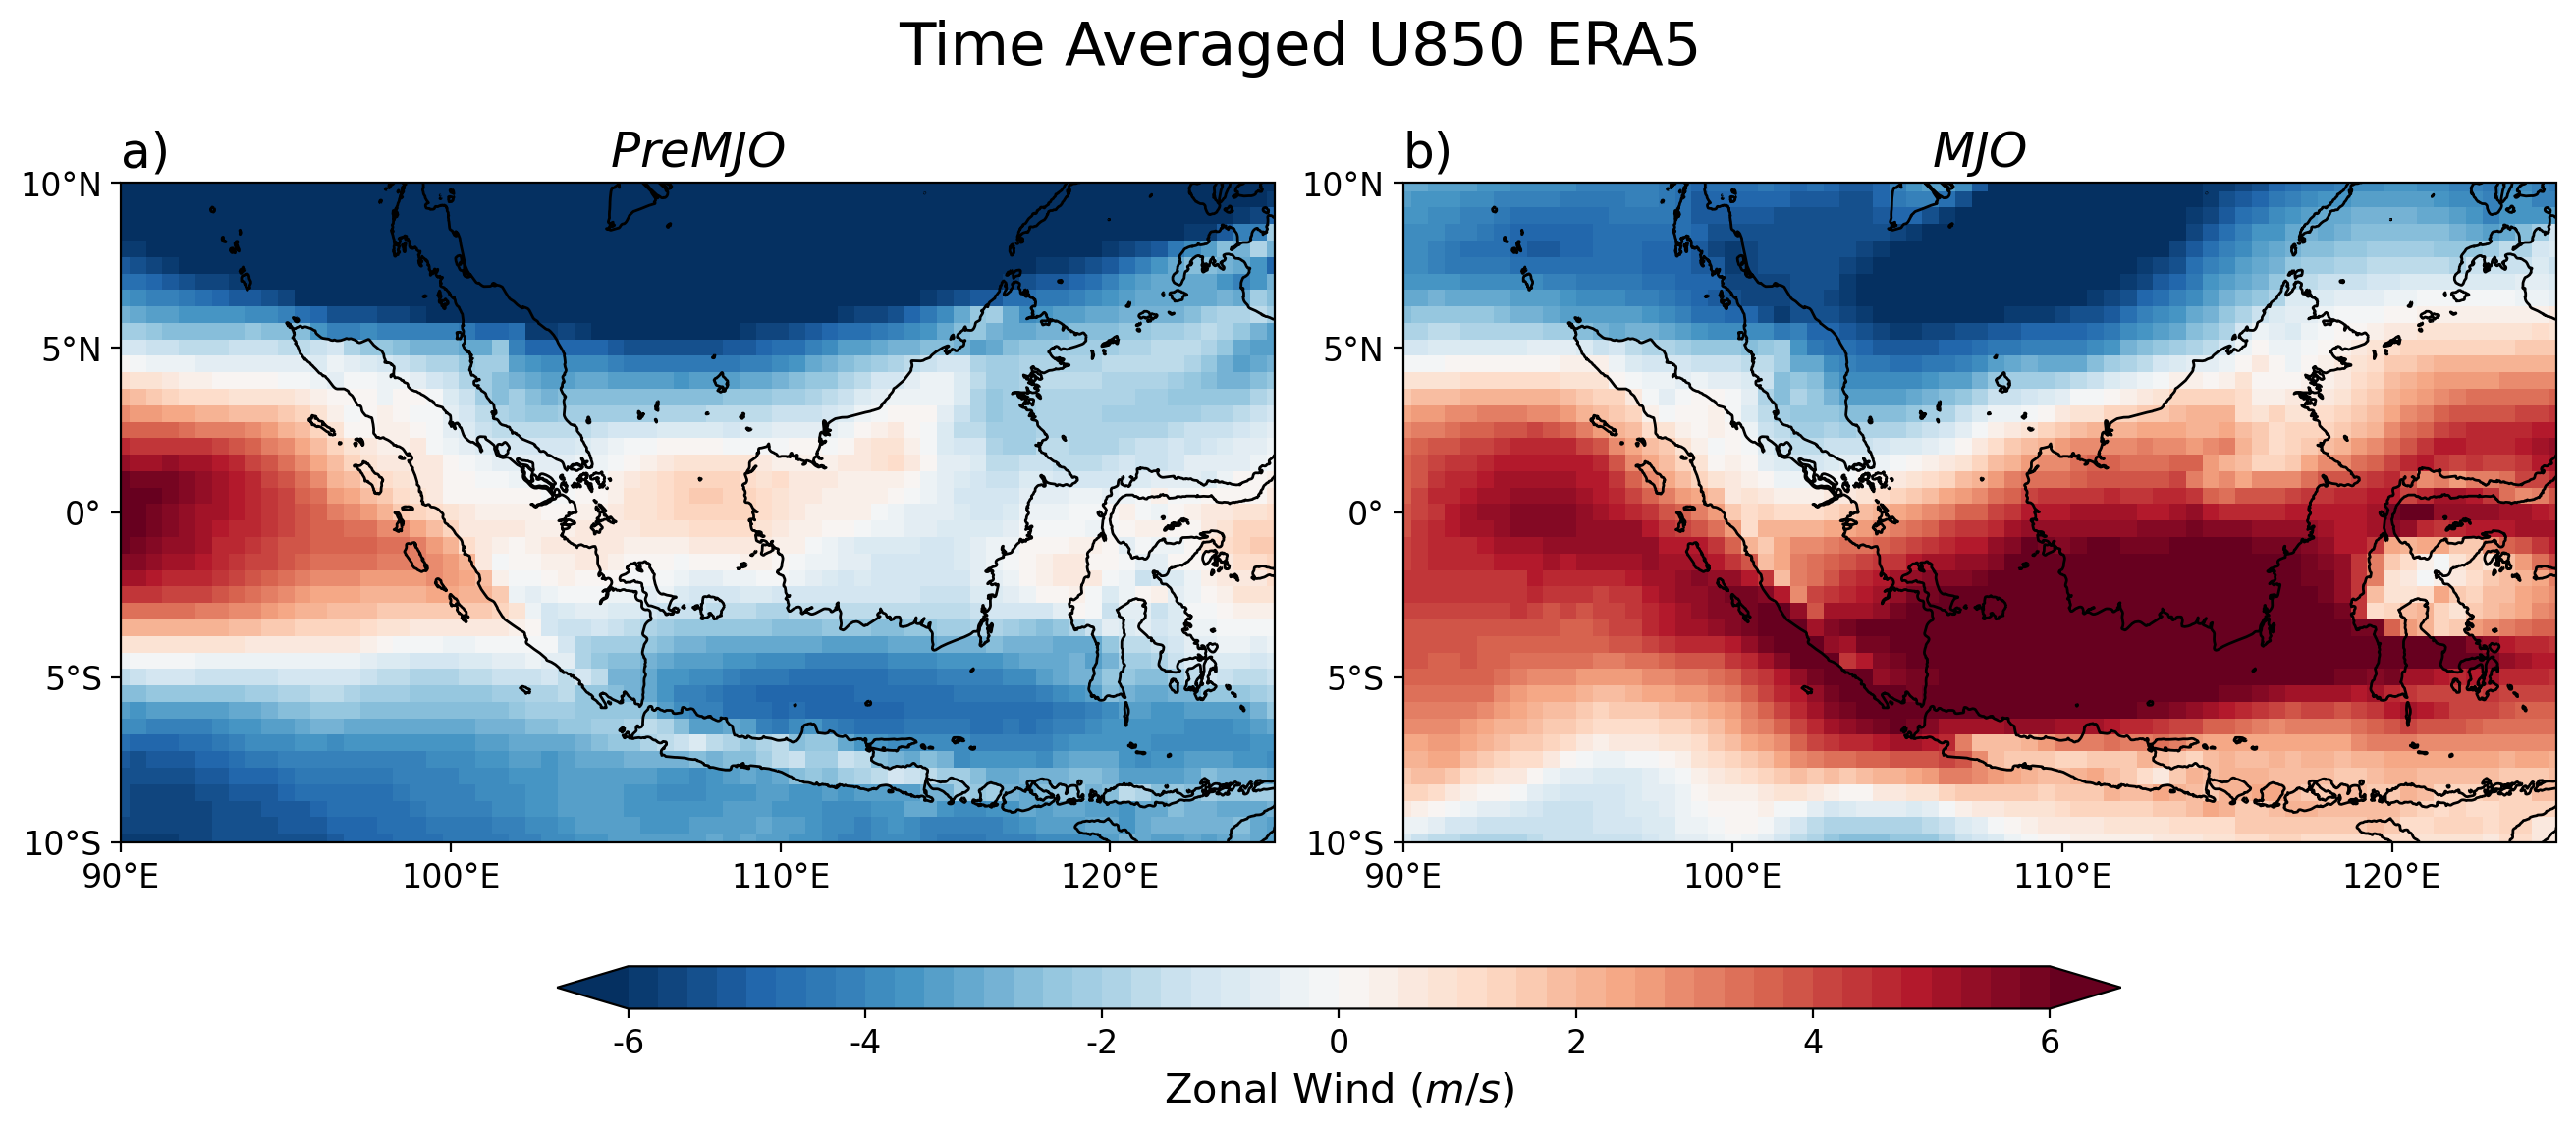

In [15]:
fig = plt.figure(figsize=(16,6))
gs = gridspec.GridSpec(nrows=2, ncols=4, hspace=.1, wspace=0.25, height_ratios=[.97,.05], width_ratios=[.15,.35,.35,.15])

fs=18

fig.suptitle('Time Averaged U850 ERA5', fontsize=fs+4, y=.95)

levels = [-6, 6]
dl = .25
lon_bound_temp = [90,125]
lat_bound_temp = [-10,10]

# Set parameters and labels
x_ticks = [90,100,110,120]
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_ticks = [-10,-5,0,5,10]
y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']

def plot_timeavg_RR(ax, da):
    cf = da.mean('time').plot(
        ax=ax,
        add_colorbar=False,
        cmap='RdBu_r',
        levels=np.arange(levels[0],levels[1]+dl,dl),
        vmin=levels[0], vmax=levels[1],
        x='longitude',
        y='latitude',
        xlim=[lon_bound_temp[0], lon_bound_temp[1]],
        ylim=[lat_bound_temp[0], lat_bound_temp[1]],
    )

    ax.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels, fontsize=fs-6)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_tick_labels, fontsize=fs-6)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim([lon_bound_temp[0],lon_bound_temp[1]])
    ax.set_ylim([lat_bound_temp[0],lat_bound_temp[1]])

    return cf

ax1 = fig.add_subplot(gs[0,0:2], projection=ccrs.PlateCarree(central_longitude=0))
cf1 = plot_timeavg_RR(ax1, da_u850_old)
ax1.set_title('$PreMJO$', fontsize=fs, loc='center')
ax1.set_title('a)', loc='left', fontsize=fs)

ax2 = fig.add_subplot(gs[0,2:4], projection=ccrs.PlateCarree(central_longitude=0))
cf2 = plot_timeavg_RR(ax2, da_u850_new)
ax2.set_title('$MJO$', fontsize=fs, loc='center')
ax2.set_title('b)', loc='left', fontsize=fs)

ax3 = fig.add_subplot(gs[1,1:3])
cbar = plt.colorbar(cf1, cax=ax3, orientation='horizontal', extend='both', ticks=np.arange(levels[0],levels[1]+1,2))
cbar.set_ticklabels(np.arange(levels[0],levels[1]+1,2), fontsize=fs-6)
cbar.minorticks_off()
cbar.set_label('Zonal Wind ($m/s$)', fontsize=fs-3)

VI QV

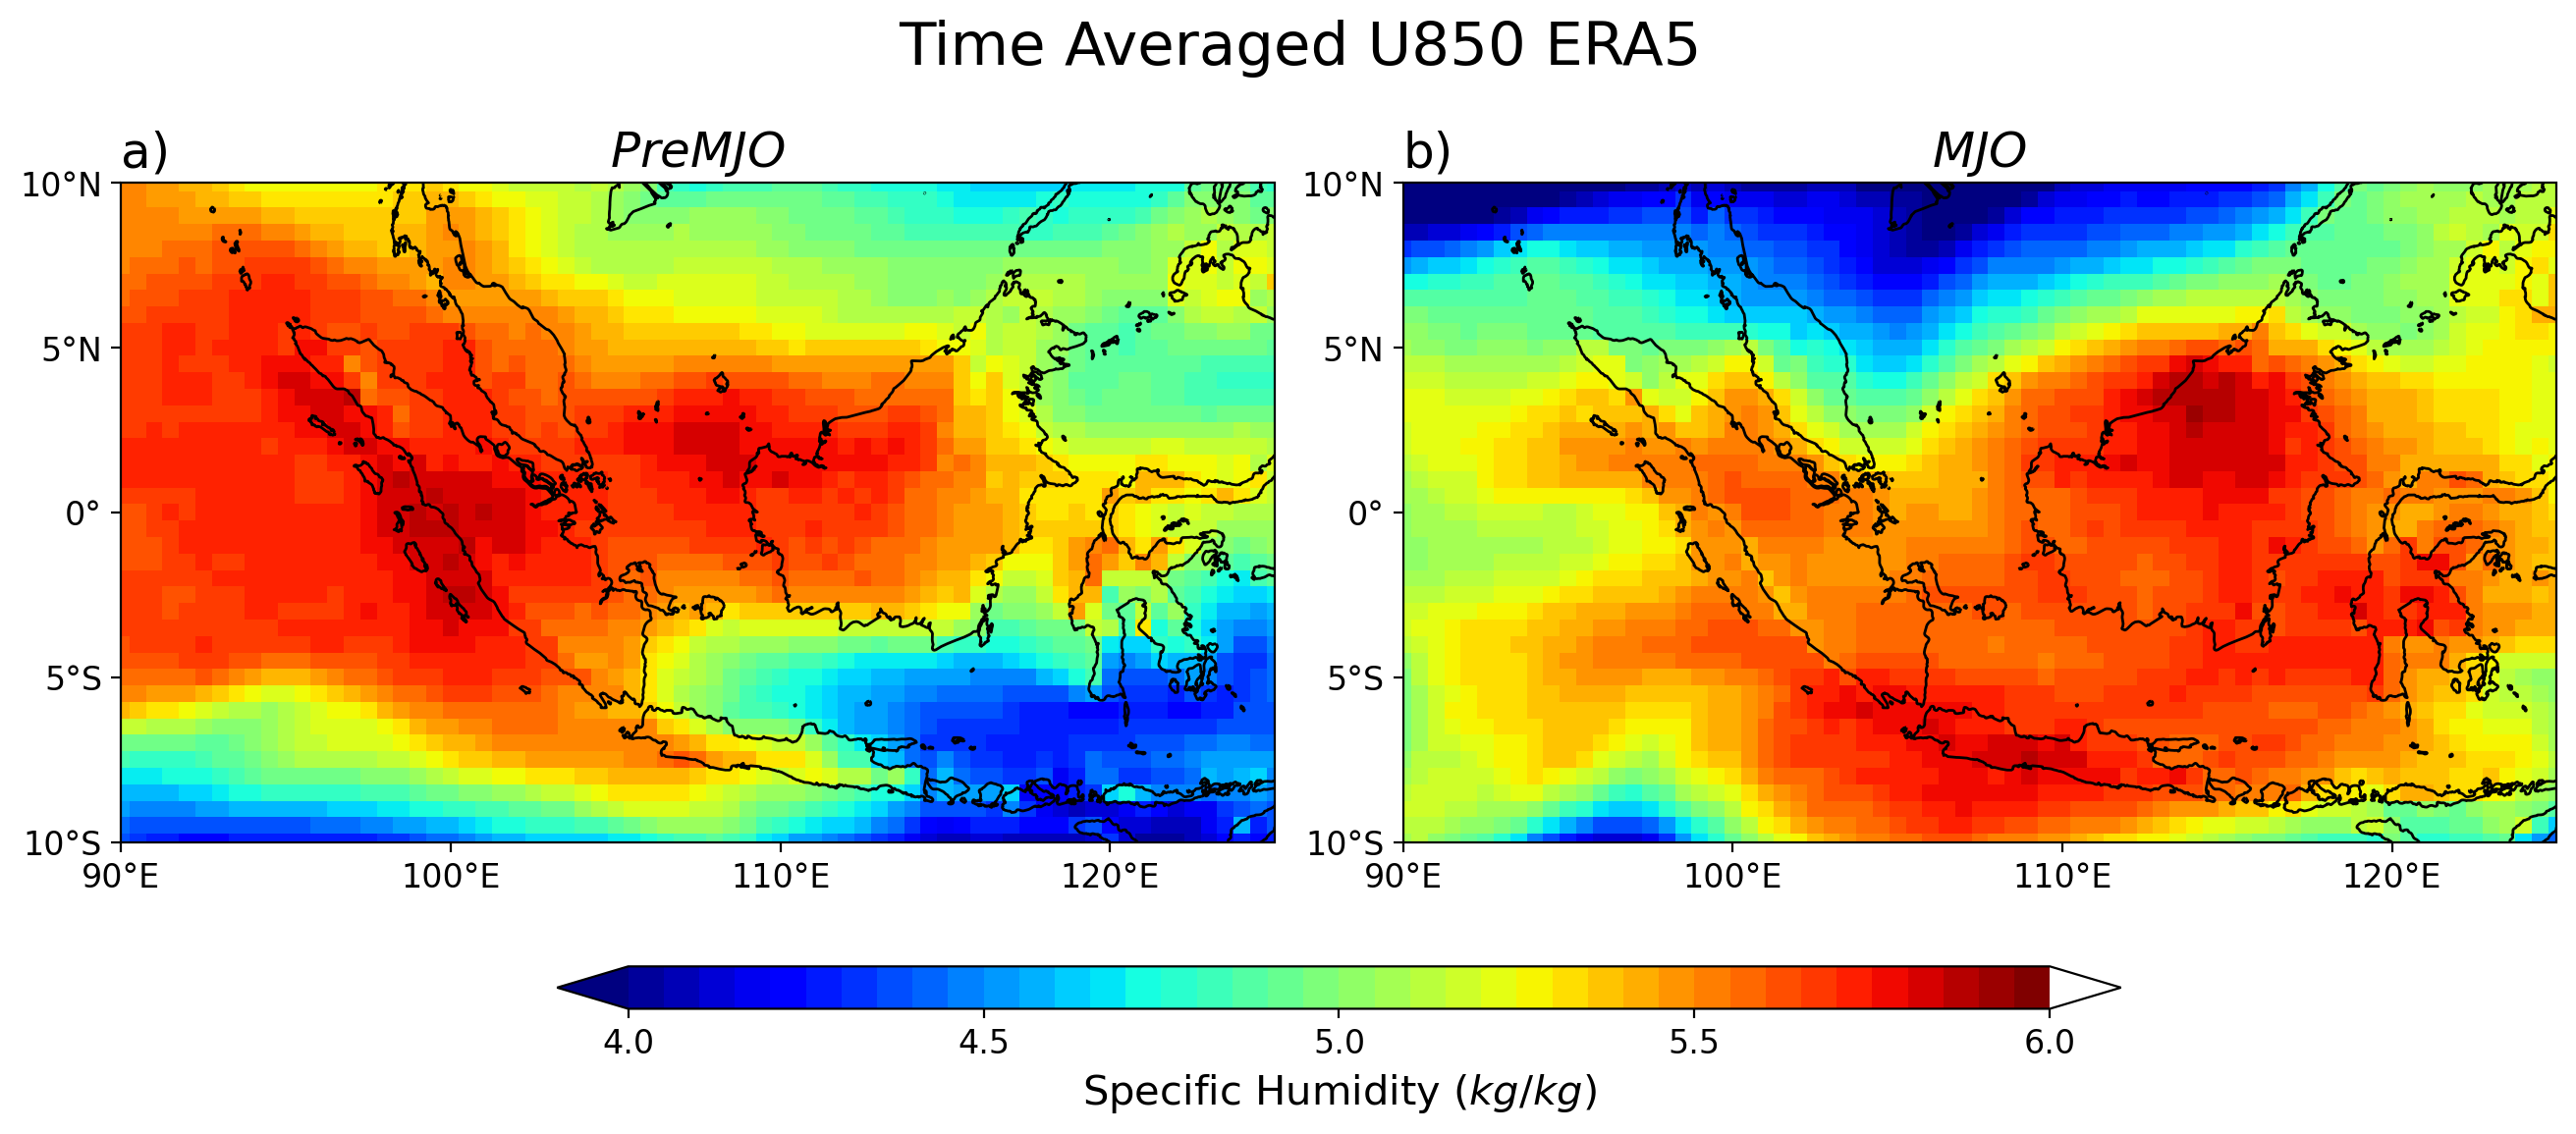

In [25]:
fig = plt.figure(figsize=(16,6))
gs = gridspec.GridSpec(nrows=2, ncols=4, hspace=.1, wspace=0.25, height_ratios=[.97,.05], width_ratios=[.15,.35,.35,.15])

fs=18

fig.suptitle('Time Averaged U850 ERA5', fontsize=fs+4, y=.95)

levels = [4, 6]
dl = .05
lon_bound_temp = [90,125]
lat_bound_temp = [-10,10]

# Set parameters and labels
x_ticks = [90,100,110,120]
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_ticks = [-10,-5,0,5,10]
y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']

def plot_timeavg_RR(ax, da):
    cf = da.mean('time').plot(
        ax=ax,
        add_colorbar=False,
        cmap='jet',
        levels=np.arange(levels[0],levels[1]+dl,dl),
        vmin=levels[0], vmax=levels[1],
        x='longitude',
        y='latitude',
        xlim=[lon_bound_temp[0], lon_bound_temp[1]],
        ylim=[lat_bound_temp[0], lat_bound_temp[1]],
    )

    ax.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels, fontsize=fs-6)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_tick_labels, fontsize=fs-6)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim([lon_bound_temp[0],lon_bound_temp[1]])
    ax.set_ylim([lat_bound_temp[0],lat_bound_temp[1]])

    return cf

ax1 = fig.add_subplot(gs[0,0:2], projection=ccrs.PlateCarree(central_longitude=0))
cf1 = plot_timeavg_RR(ax1, da_intq_old)
ax1.set_title('$PreMJO$', fontsize=fs, loc='center')
ax1.set_title('a)', loc='left', fontsize=fs)

ax2 = fig.add_subplot(gs[0,2:4], projection=ccrs.PlateCarree(central_longitude=0))
cf2 = plot_timeavg_RR(ax2, da_intq_new)
ax2.set_title('$MJO$', fontsize=fs, loc='center')
ax2.set_title('b)', loc='left', fontsize=fs)

ax3 = fig.add_subplot(gs[1,1:3])
cbar = plt.colorbar(cf2, cax=ax3, orientation='horizontal', extend='both', ticks=np.arange(levels[0],levels[1]+1,.5))
cbar.set_ticklabels(np.arange(levels[0],levels[1]+1,.5), fontsize=fs-6)
cbar.minorticks_off()
cbar.set_label('Specific Humidity ($kg/kg$)', fontsize=fs-3)

### Hovmoller

u-850

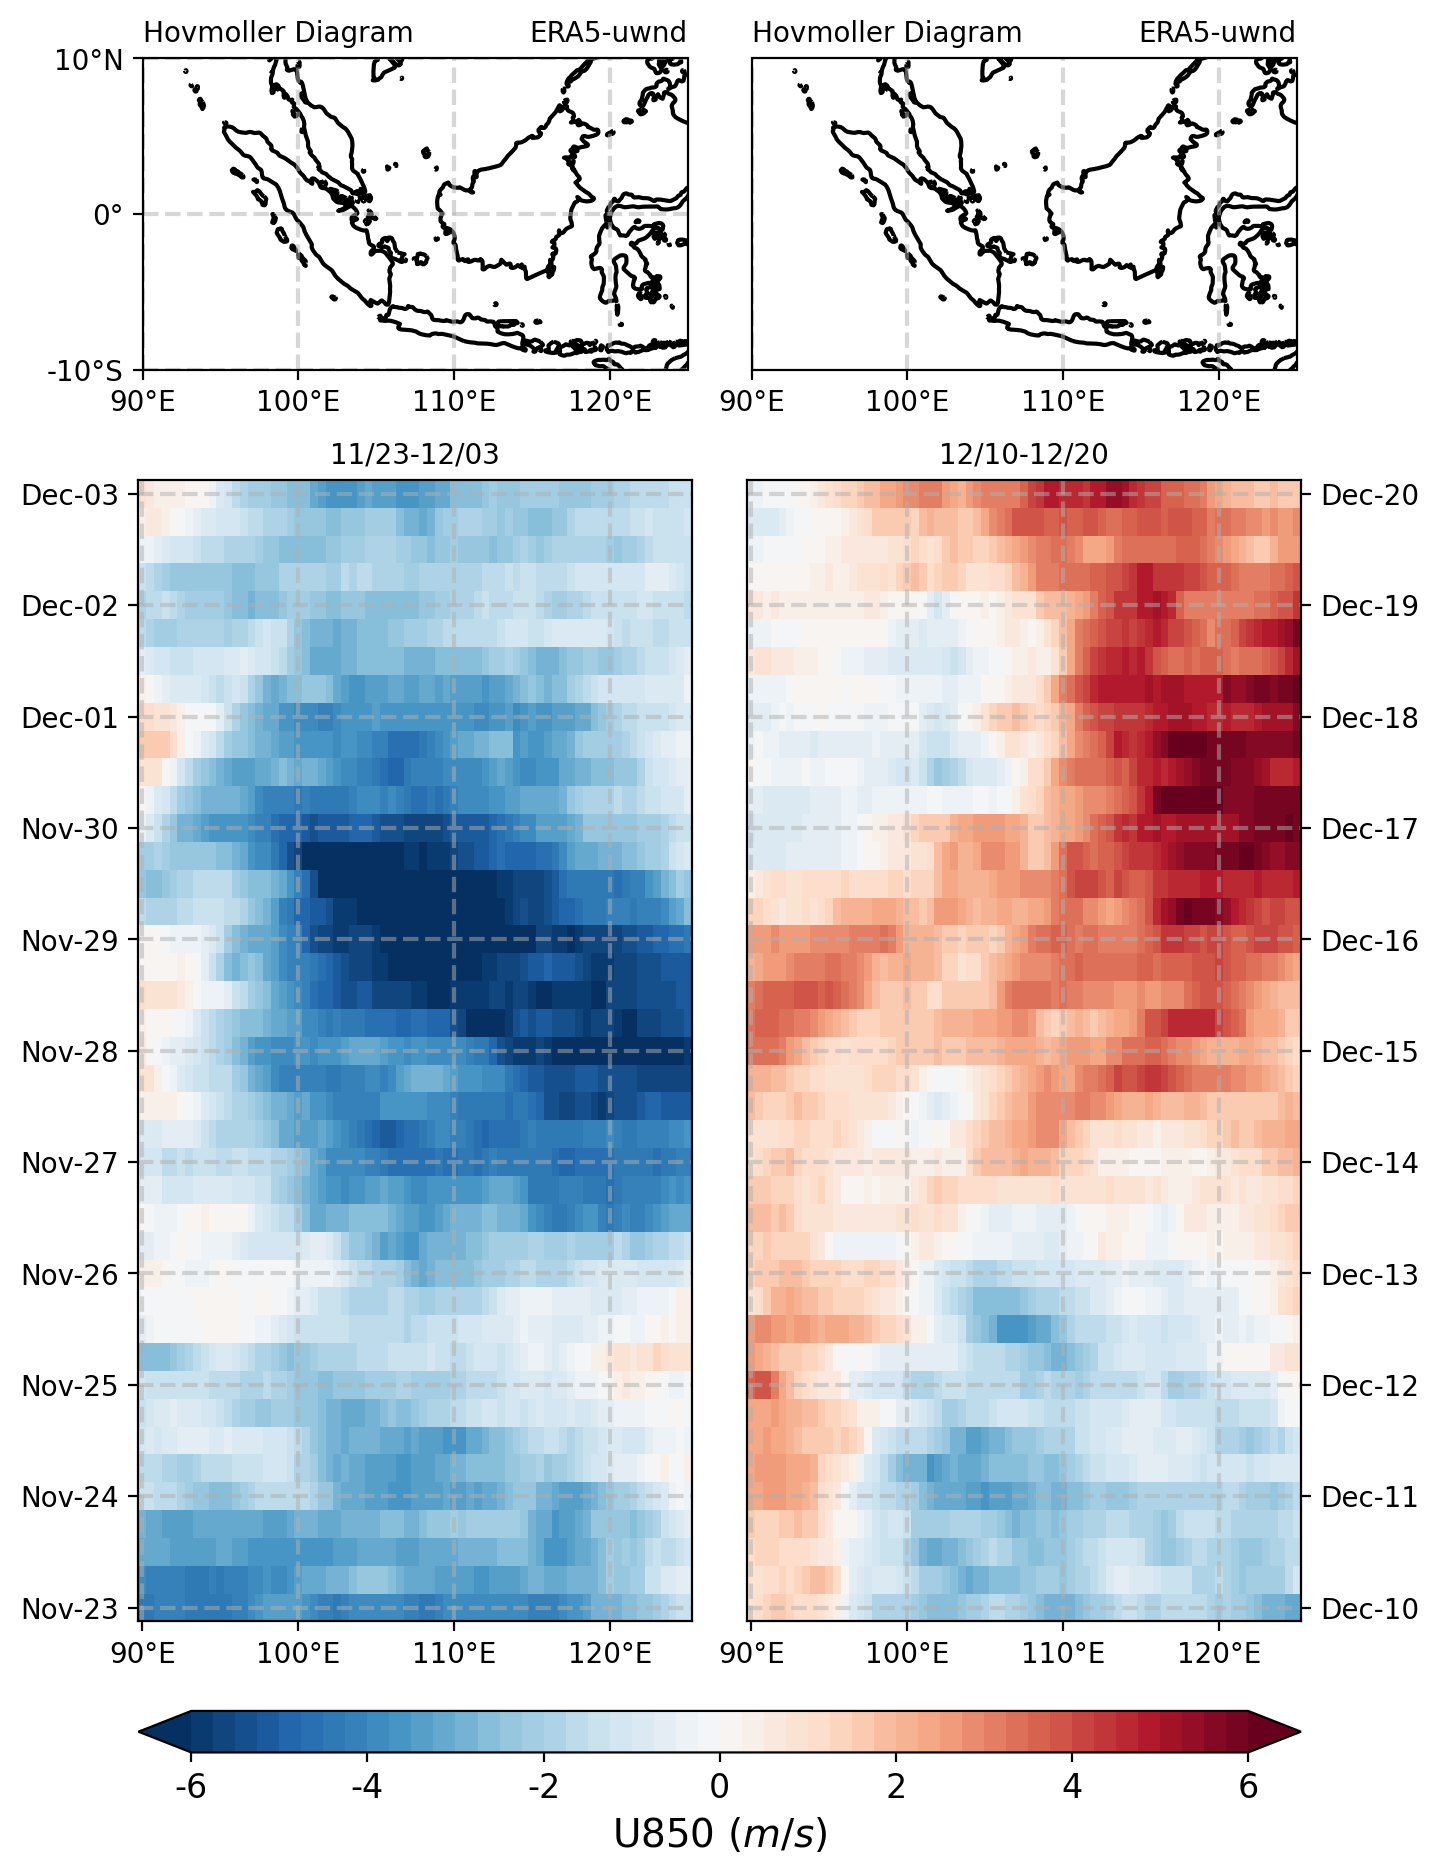

In [29]:
clevel = [-6,6]
cdl = .25
cdl_cbar = 2
levs = np.arange(clevel[0], clevel[1]+cdl, cdl)
levs_cbar = np.arange(clevel[0], clevel[1]+cdl_cbar, cdl_cbar)

#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(7.5,11))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, wspace=0.1, height_ratios=[0.15,0.03,0.55,0.02,0.02], width_ratios=[.5,.5])

## Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound[0], lon_bound[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-10, 0, 10])
ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'10\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(lon_bound[0],lon_bound[1],10))
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5, alpha=.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
ax1.set_title('Hovmoller Diagram', loc='left', fontsize=10)
ax1.set_title('ERA5-uwnd', loc='right', fontsize=10)

## Top plot for geographic reference (makes small map)
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree(central_longitude=0))
ax2.set_extent([lon_bound[0], lon_bound[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
# ax2.set_yticks([-10, 0, 10])
# ax2.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'10\N{DEGREE SIGN}N'])
ax2.set_xticks(np.arange(lon_bound[0],lon_bound[1],10))
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
ax2.set_xticklabels(x_tick_labels)
ax2.grid(linestyle='--', linewidth=1.5, alpha=.5)
# Plot the coast lines
ax2.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
ax2.set_title('Hovmoller Diagram', loc='left', fontsize=10)
ax2.set_title('ERA5-uwnd', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################

ax3 = fig.add_subplot(gs[2, 0])
## Preparing data to be plotted
# Plot the rain rates
cf1 = da_u850_old.mean('latitude').plot(
	ax=ax3,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1],10),
	cmap='RdBu_r',
	levels=levs,
	extend='both'
)
# Create grids
ax3.grid(linestyle='--', linewidth=1.5, alpha=.5)
ax3.set_title('11/23-12/03', loc='center', fontsize=10)
ax3.set_xticklabels(x_tick_labels)
t = da_u850_old.time[::4].dt.strftime("%b-%d")
ax3.set_yticks(da_u850_old.time[::4])
ax3.set_yticklabels(t.values)
ax3.set_xlabel('')
ax3.set_ylabel('')


ax4 = fig.add_subplot(gs[2, 1])
## Preparing data to be plotted
# Plot the rain rates
cf2 = da_u850_new.mean('latitude').plot(
    ax=ax4,
    add_colorbar=False,
    xticks=np.arange(lon_bound[0], lon_bound[1], 10),
    cmap='RdBu_r',
    levels=np.arange(clevel[0], clevel[1]+cdl, cdl),
    extend='both'
)
# Create grids
ax4.grid(linestyle='--', linewidth=1.5, alpha=0.5)
ax4.set_title('12/10-12/20', loc='center', fontsize=10)
ax4.set_xticklabels(x_tick_labels)
# Set y-ticks
t = da_u850_new.time[::4].dt.strftime("%b-%d")
ax4.set_yticks(da_u850_new.time[::4])
ax4.set_yticklabels(t.values)
# Move y-axis ticks and labels to the right
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position('right')
ax4.set_xlabel('')
ax4.set_ylabel('')

# Plot the colorbars
	# Rain rate colorbar
ax5 = fig.add_subplot(gs[4, :])
cbar = plt.colorbar(cf2, cax=ax5, orientation='horizontal', pad=0.5, aspect=100, extend='both')
cbar.set_ticks(levs_cbar)
cbar.minorticks_off()
cbar.set_ticklabels(levs_cbar, fontsize=fs-6)
cbar.set_label('U850 ($m/s$)', fontsize=fs-4)

q-700

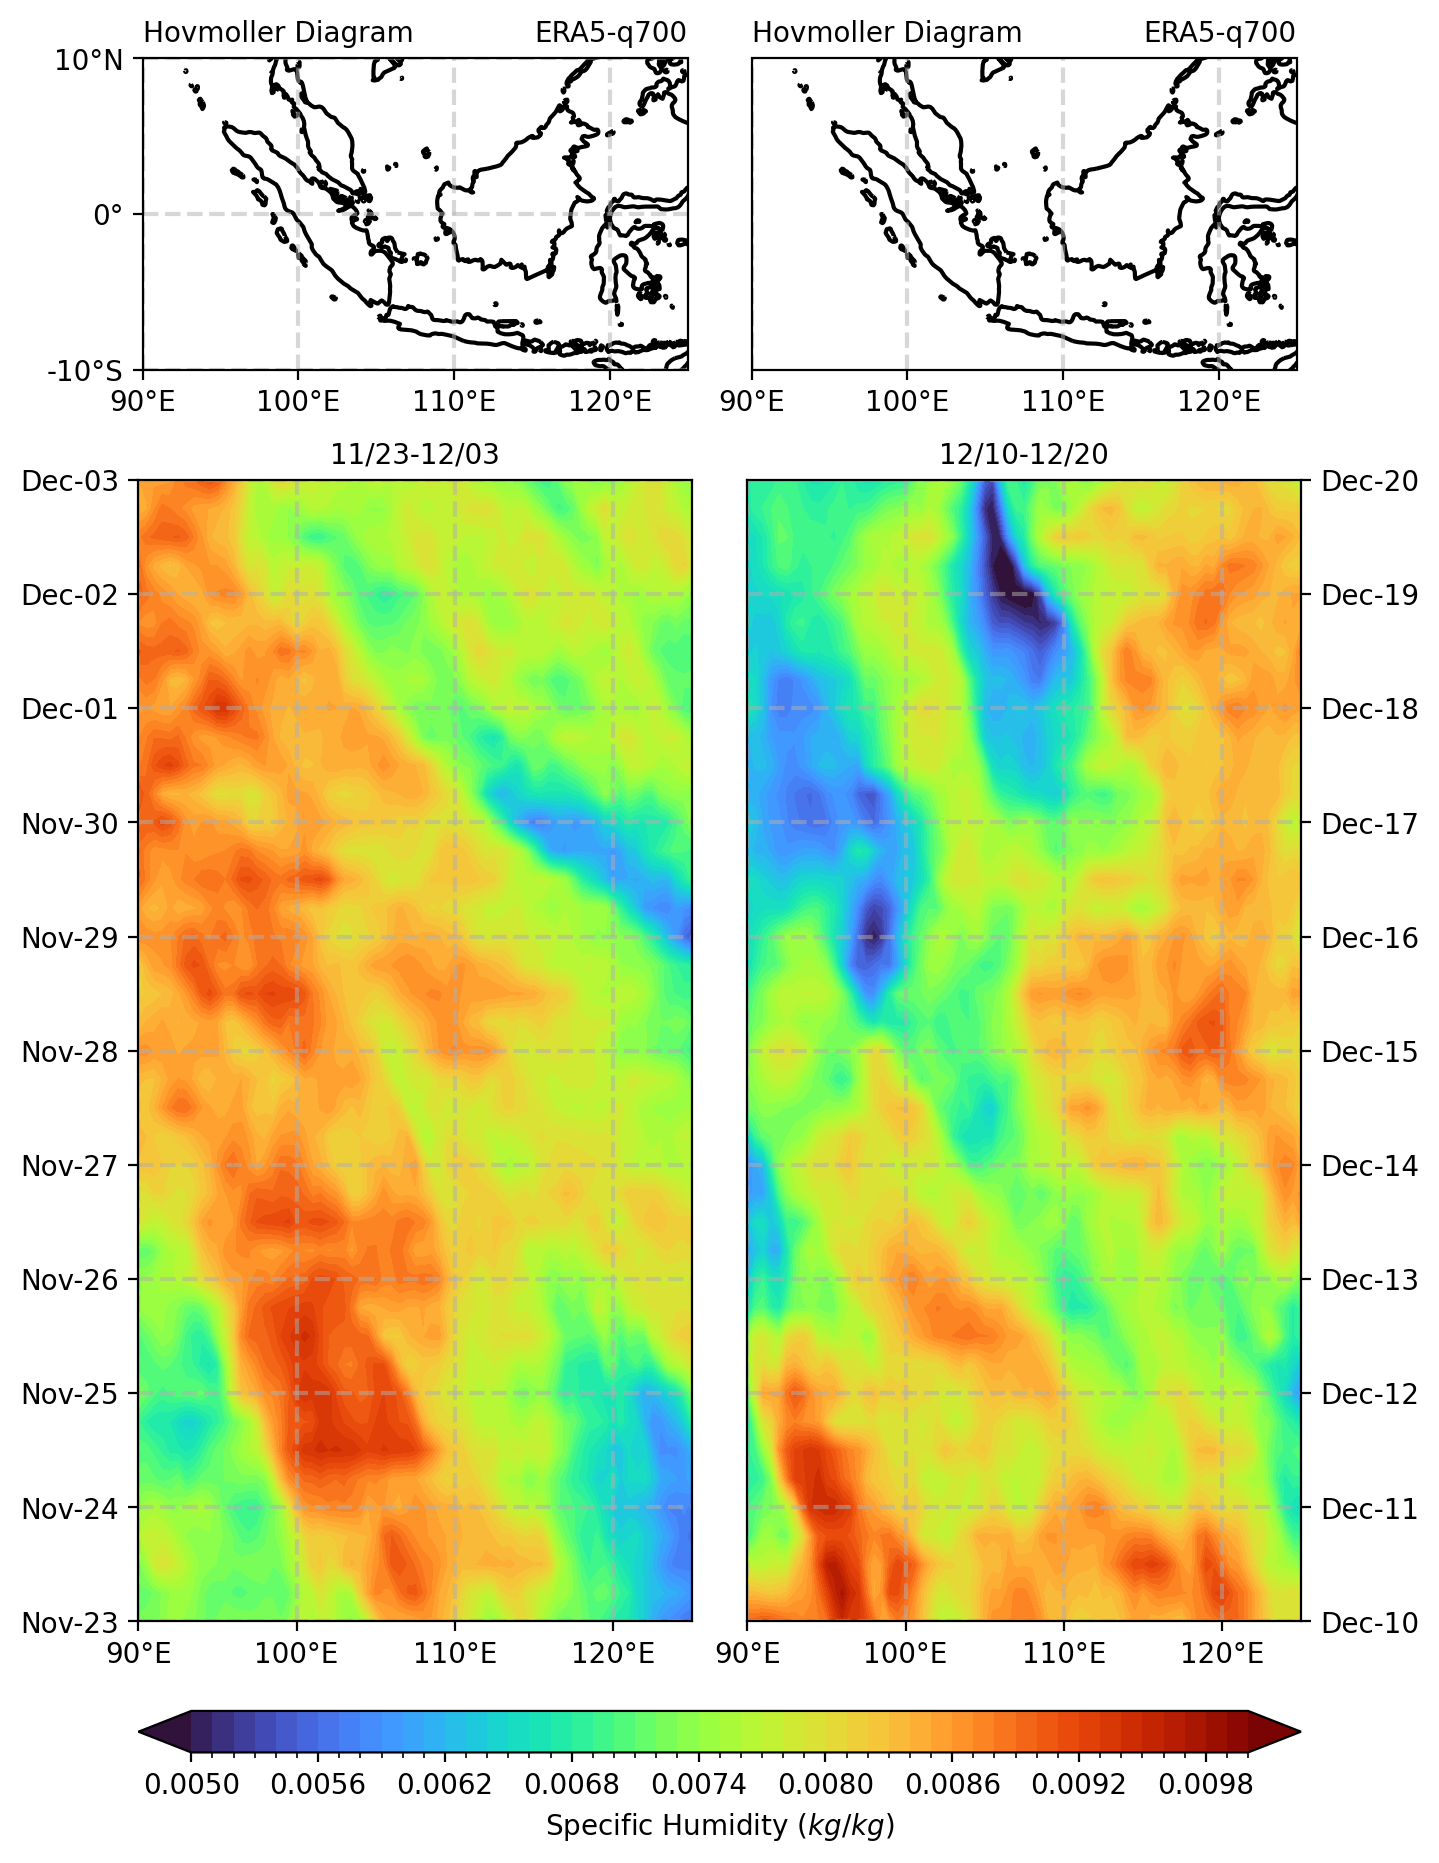

In [85]:
clevel = [0.005,.01]
cdl = .0001

#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(7.5,11))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, wspace=0.1, height_ratios=[0.15,0.03,0.55,0.02,0.02], width_ratios=[.5,.5])

## Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound[0], lon_bound[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-10, 0, 10])
ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'10\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(lon_bound[0],lon_bound[1],10))
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5, alpha=.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
ax1.set_title('Hovmoller Diagram', loc='left', fontsize=10)
ax1.set_title('ERA5-q700', loc='right', fontsize=10)

## Top plot for geographic reference (makes small map)
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree(central_longitude=0))
ax2.set_extent([lon_bound[0], lon_bound[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
# ax2.set_yticks([-10, 0, 10])
# ax2.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'10\N{DEGREE SIGN}N'])
ax2.set_xticks(np.arange(lon_bound[0],lon_bound[1],10))
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
ax2.set_xticklabels(x_tick_labels)
ax2.grid(linestyle='--', linewidth=1.5, alpha=.5)
# Plot the coast lines
ax2.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
ax2.set_title('Hovmoller Diagram', loc='left', fontsize=10)
ax2.set_title('ERA5-q700', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################

ax3 = fig.add_subplot(gs[2, 0])
## Preparing data to be plotted
# Plot the rain rates
cf1 = da_q700_old.mean('latitude').plot.contourf(
	ax=ax3,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1],10),
	cmap='turbo',
	levels=np.arange(clevel[0], clevel[1]+cdl, cdl),
	extend='both'
)
# Create grids
ax3.grid(linestyle='--', linewidth=1.5, alpha=.5)
ax3.set_title('11/23-12/03', loc='center', fontsize=10)
ax3.set_xticklabels(x_tick_labels)
t = da_q700_old.time[::4].dt.strftime("%b-%d")
ax3.set_yticks(da_q700_old.time[::4])
ax3.set_yticklabels(t.values)
ax3.set_xlabel('')
ax3.set_ylabel('')


ax4 = fig.add_subplot(gs[2, 1])
## Preparing data to be plotted
# Plot the rain rates
cf2 = da_q700_new.mean('latitude').plot.contourf(
    ax=ax4,
    add_colorbar=False,
    xticks=np.arange(lon_bound[0], lon_bound[1], 10),
    cmap='turbo',
    levels=np.arange(clevel[0], clevel[1]+cdl, cdl),
    extend='both'
)
# Create grids
ax4.grid(linestyle='--', linewidth=1.5, alpha=0.5)
ax4.set_title('12/10-12/20', loc='center', fontsize=10)
ax4.set_xticklabels(x_tick_labels)
# Set y-ticks
t = da_q700_new.time[::4].dt.strftime("%b-%d")
ax4.set_yticks(da_q700_new.time[::4])
ax4.set_yticklabels(t.values)
# Move y-axis ticks and labels to the right
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position('right')
ax4.set_xlabel('')
ax4.set_ylabel('')

# Plot the colorbars
	# Rain rate colorbar
ax5 = fig.add_subplot(gs[4, :])
cbar2 = plt.colorbar(cf2, cax=ax5, orientation='horizontal', pad=0.5, aspect=100, extend='both')
cbar2.set_label('Specific Humidity ($kg/kg$)')

q-[1000-100]

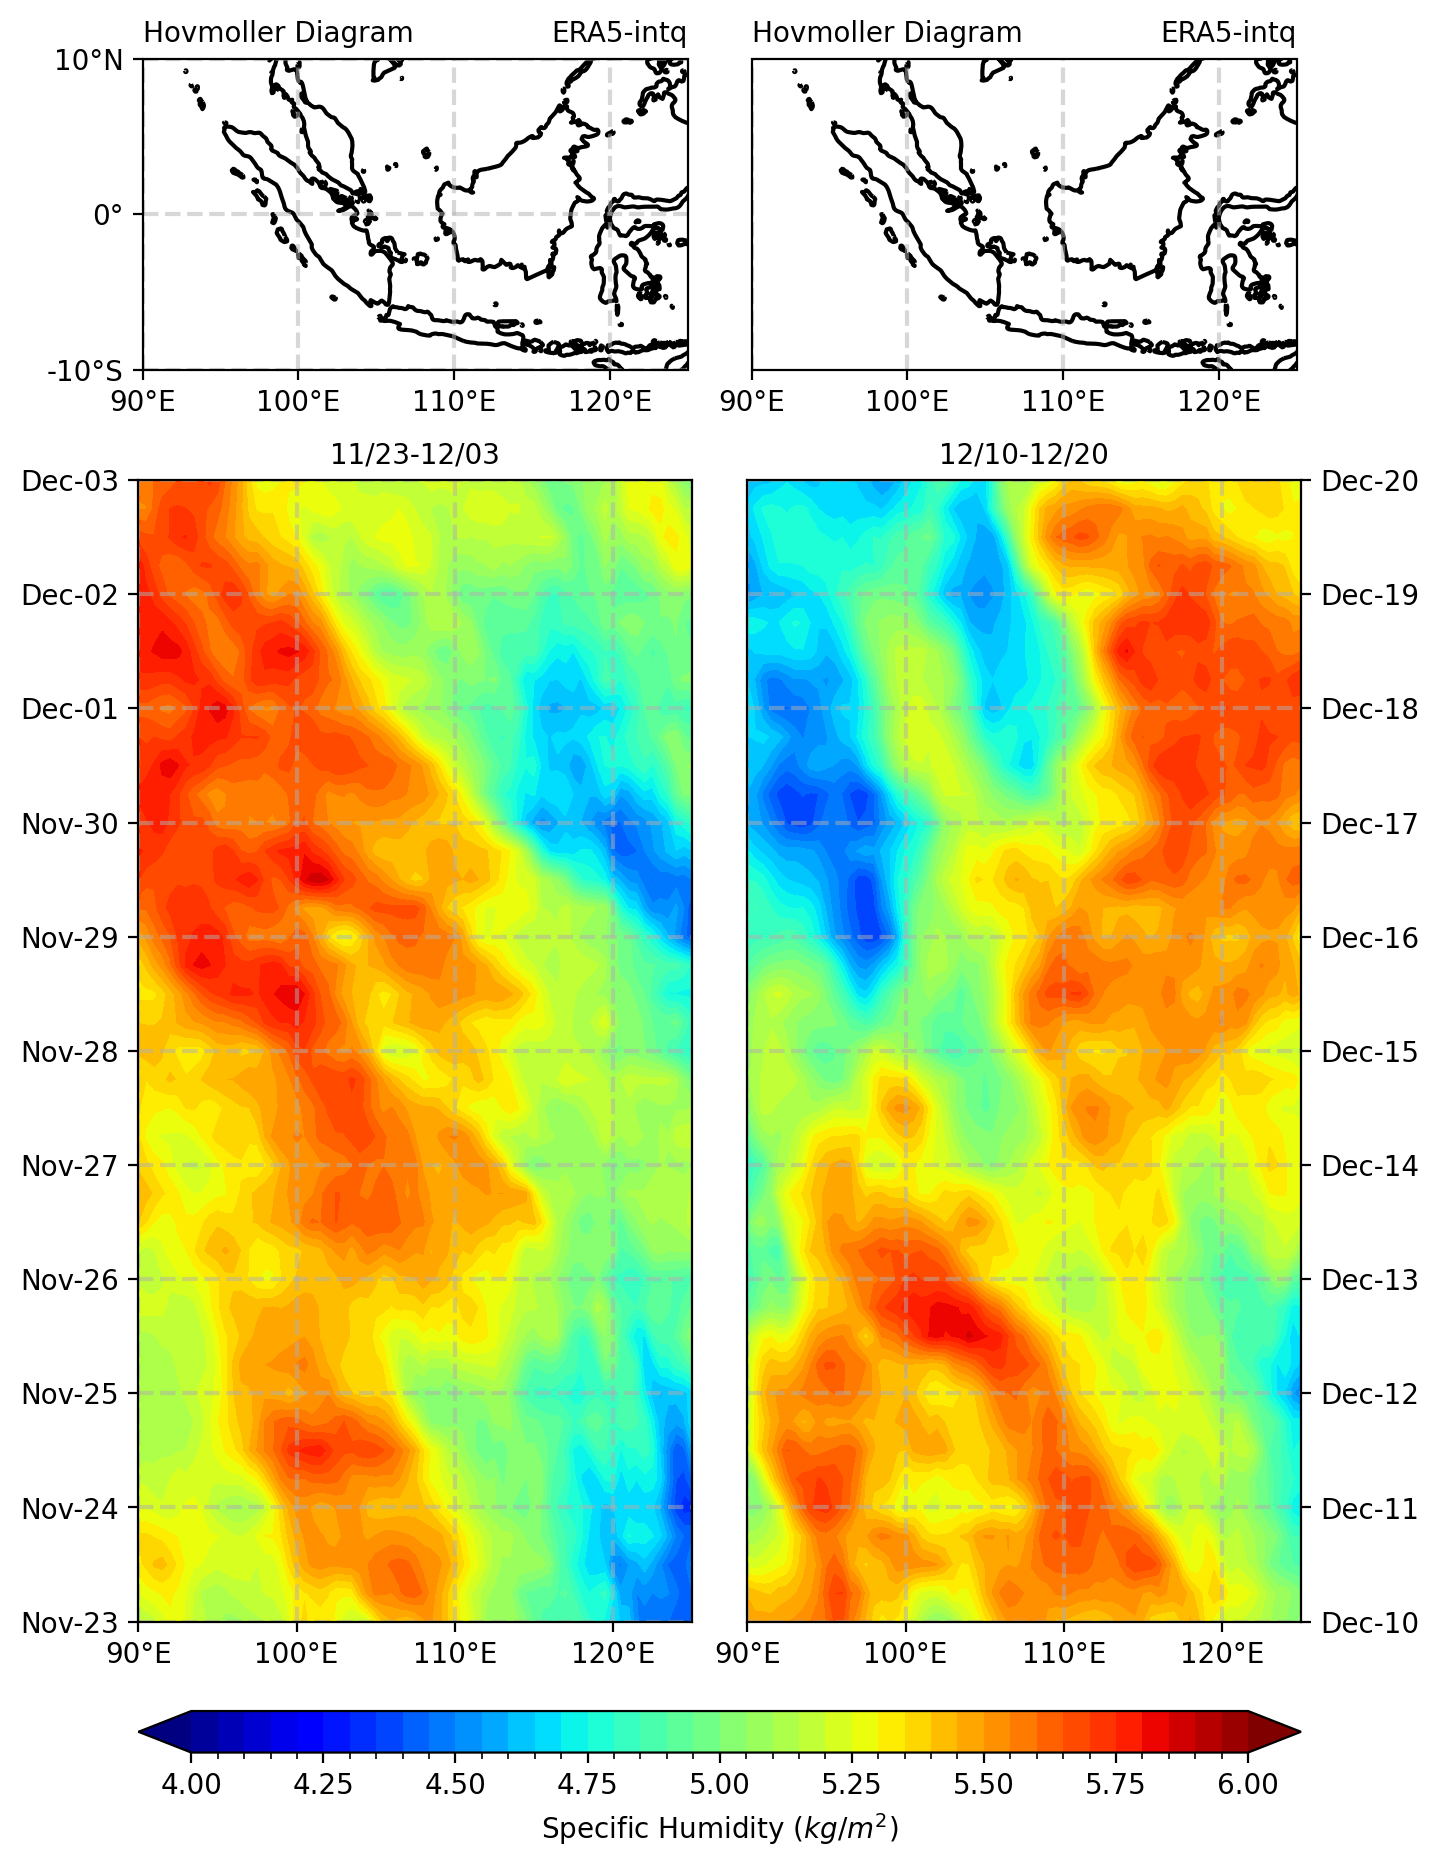

In [30]:
clevel = [4,6]
cdl = .05

#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(7.5,11))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, wspace=0.1, height_ratios=[0.15,0.03,0.55,0.02,0.02], width_ratios=[.5,.5])

## Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound[0], lon_bound[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-10, 0, 10])
ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'10\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(lon_bound[0],lon_bound[1],10))
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5, alpha=.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
ax1.set_title('Hovmoller Diagram', loc='left', fontsize=10)
ax1.set_title('ERA5-intq', loc='right', fontsize=10)

## Top plot for geographic reference (makes small map)
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree(central_longitude=0))
ax2.set_extent([lon_bound[0], lon_bound[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
# ax2.set_yticks([-10, 0, 10])
# ax2.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'10\N{DEGREE SIGN}N'])
ax2.set_xticks(np.arange(lon_bound[0],lon_bound[1],10))
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
ax2.set_xticklabels(x_tick_labels)
ax2.grid(linestyle='--', linewidth=1.5, alpha=.5)
# Plot the coast lines
ax2.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
ax2.set_title('Hovmoller Diagram', loc='left', fontsize=10)
ax2.set_title('ERA5-intq', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################

ax3 = fig.add_subplot(gs[2, 0])
## Preparing data to be plotted
# Plot the rain rates
cf1 = da_intq_old.mean('latitude').plot.contourf(
	ax=ax3,
	add_colorbar=False,
	xticks=np.arange(lon_bound[0],lon_bound[1],10),
	cmap='jet',
	levels=np.arange(clevel[0], clevel[1]+cdl, cdl),
	extend='both'
)
# Create grids
ax3.grid(linestyle='--', linewidth=1.5, alpha=.5)
ax3.set_title('11/23-12/03', loc='center', fontsize=10)
ax3.set_xticklabels(x_tick_labels)
t = da_intq_old.time[::4].dt.strftime("%b-%d")
ax3.set_yticks(da_intq_old.time[::4])
ax3.set_yticklabels(t.values)
ax3.set_xlabel('')
ax3.set_ylabel('')


ax4 = fig.add_subplot(gs[2, 1])
## Preparing data to be plotted
# Plot the rain rates
cf2 = da_intq_new.mean('latitude').plot.contourf(
    ax=ax4,
    add_colorbar=False,
    xticks=np.arange(lon_bound[0], lon_bound[1], 10),
    cmap='jet',
    levels=np.arange(clevel[0], clevel[1]+cdl, cdl),
    extend='both'
)
# Create grids
ax4.grid(linestyle='--', linewidth=1.5, alpha=0.5)
ax4.set_title('12/10-12/20', loc='center', fontsize=10)
ax4.set_xticklabels(x_tick_labels)
# Set y-ticks
t = da_intq_new.time[::4].dt.strftime("%b-%d")
ax4.set_yticks(da_intq_new.time[::4])
ax4.set_yticklabels(t.values)
# Move y-axis ticks and labels to the right
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position('right')
ax4.set_xlabel('')
ax4.set_ylabel('')

# Plot the colorbars
	# Rain rate colorbar
ax5 = fig.add_subplot(gs[4, :])
cbar2 = plt.colorbar(cf2, cax=ax5, orientation='horizontal', pad=0.5, aspect=100, extend='both')
cbar2.set_label('Specific Humidity ($kg/m^{2}$)')